**1. Open the ATL06 HDF files.** Put the needed info in a dictionary, save the whole thing to file.

In [1]:
import arc
# atl06_file_name = 'brunt_atl06.pickle'
# arc.ingest('/Users/lipovsky/is2-data/brunt',atl06_file_name)

atl06_file_name = 'amery_atl06.pickle'
arc.ingest('/Users/lipovsky/is2-data/amery',atl06_file_name)

import pickle
# Load data (deserialize)
with open(atl06_file_name, 'rb') as handle:
    atl06_data = pickle.load(handle)

Runtime was:  0:00:28.223916


**2. Verify the data** by making a plot of the ATL06 data

<IPython.core.display.Javascript object>


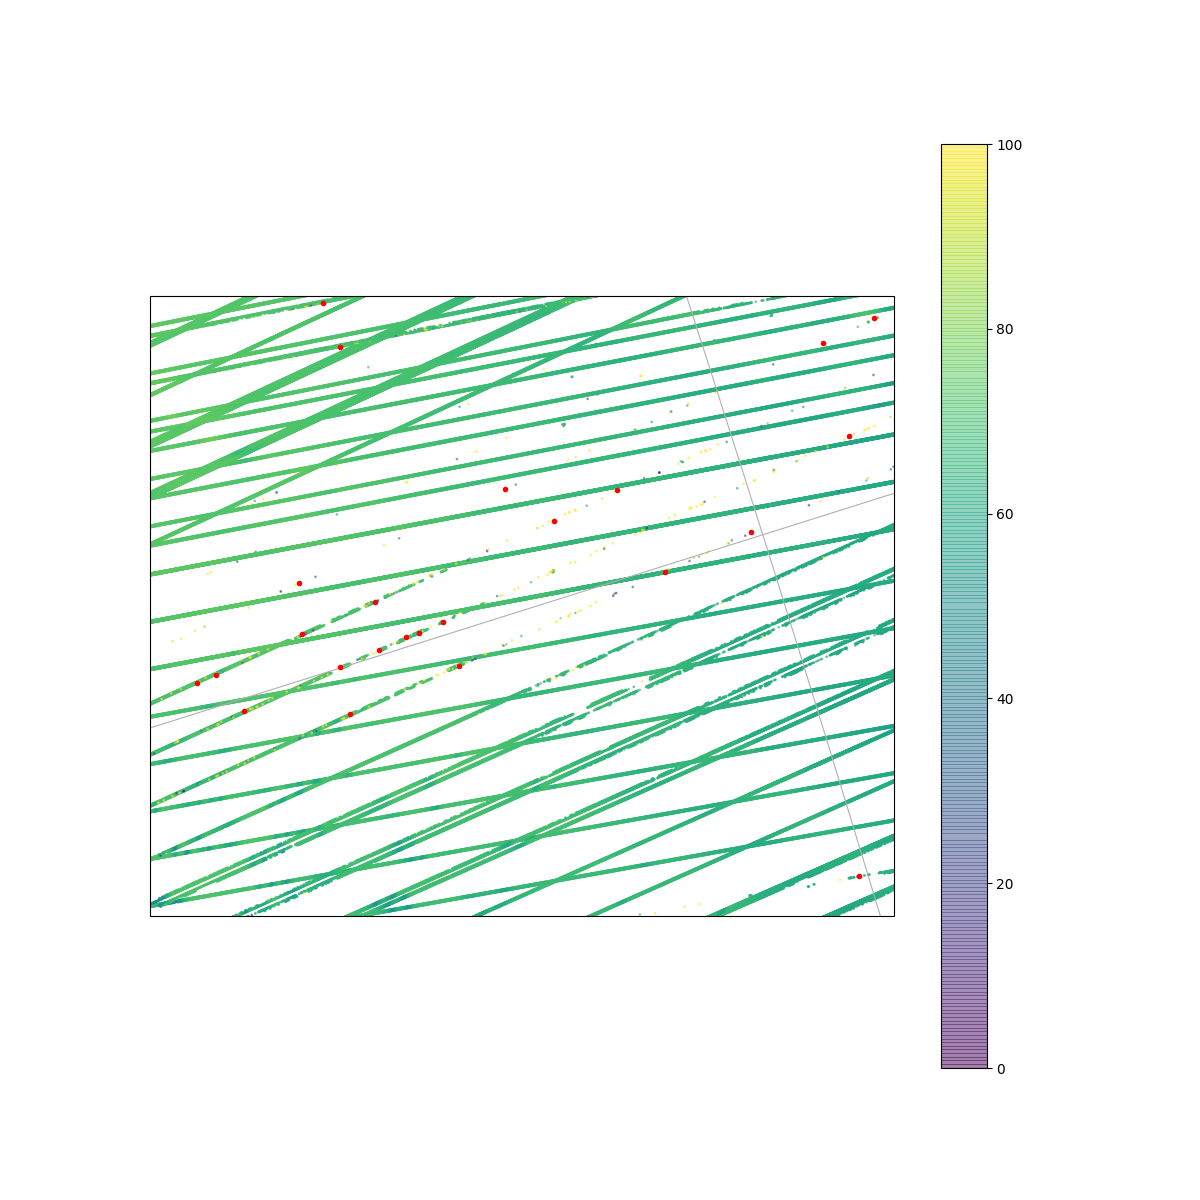

Runtime was:  0:00:13.019654


In [14]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
%matplotlib notebook
from datetime import datetime

ttstart = datetime.now()
fig = plt.figure(figsize=[12, 12])
ax  = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

ax.gridlines(draw_labels=True, dms=True ,  x_inline=False, y_inline=False)

thr = 4
sig_thr = 1

for lat, lon, h, sig in zip(atl06_data['lat'][0:1000], 
                            atl06_data['lon'][0:1000], 
                            atl06_data['h'], 
                            atl06_data['h_sig']):
    sc = ax.scatter(lon[(h>thr)&(sig<sig_thr)],lat[(h>thr)&(sig<sig_thr)],
                    c=h[(h>thr)&(sig<sig_thr)],s=1,vmin=0,vmax=100,alpha=0.5,
                    transform=ccrs.PlateCarree())
plt.colorbar(sc)

for lat, lon, h, sig in zip(atl06_data['lat'][0:1000], 
                            atl06_data['lon'][0:1000], 
                            atl06_data['h'], 
                            atl06_data['h_sig']):
    
    ax.plot(lon[abs(h)<thr],lat[abs(h)<thr],'.r', transform=ccrs.PlateCarree())

plt.show()

ttend = datetime.now()
print('Runtime was: ', ttend - ttstart)

**3. Find the rifts in the ATL06 data**

In [15]:
rift_obs = arc.get_rifts(atl06_data)

/Users/lipovsky/Google Drive/Science/brunt/arc.py:182: RuntimeWarning: Mean of empty slice.
  rift_azi.append ( row['azimuth'][rift_coords[0]:rift_coords[1]].mean()   )
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/lipovsky/Google Drive/Science/brunt/arc.py:183: RuntimeWarning: Mean of empty slice.
  rift_sig.append ( row['h_sig'][rift_coords[0]:rift_coords[1]].mean()  )
/Users/lipovsky/Google Drive/Science/brunt/arc.py:184: RuntimeWarning: Mean of empty slice.
  rift_h.append   ( row['h'][rift_coords[0]:rift_coords[1]].mean()  )


Run time: 0:00:00.633799


**4. Plot the rift catalog**

<IPython.core.display.Javascript object>


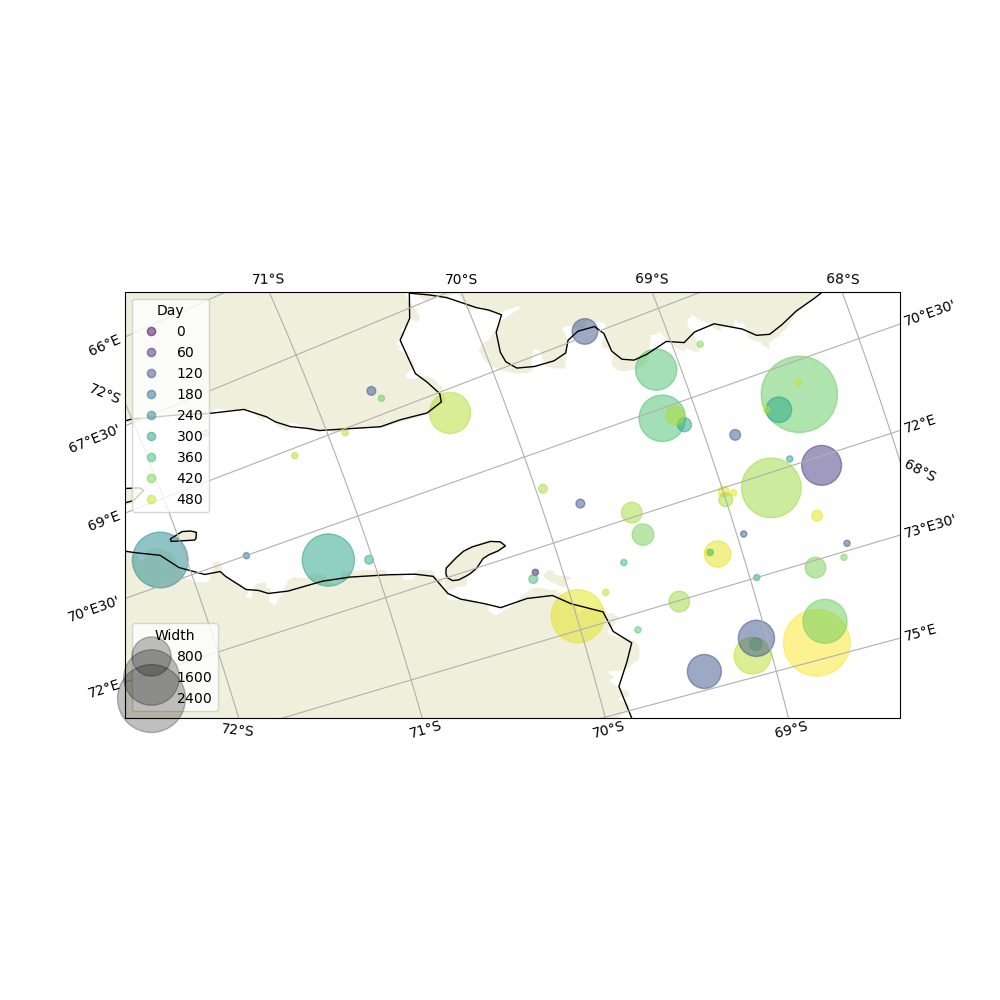

In [16]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import numpy as np

# fig,ax=plt.subplots()
fig = plt.figure(figsize=[10, 10])
ax  = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

ax.gridlines(draw_labels=True, dms=True ,  x_inline=False, y_inline=False)

times = pd.to_datetime(rift_obs['time']).astype(int)/ 10**9
time_func = (times-min(abs(times))) / 86400

sc = ax.scatter(rift_obs['lat'],rift_obs['lon'],
           transform=ccrs.PlateCarree(), s=np.array(rift_obs['width']),
           c=time_func,alpha=0.5)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*sc.legend_elements(num=10), loc="upper left", title="Day")
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = sc.legend_elements(prop="sizes", alpha=0.25,num=5)
legend2 = ax.legend(handles, labels, loc="lower left", title="Width")

plt.show()

**5. Verify the results.**  Plot the rift detections along with the ATL06 data.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

atl06_data=pd.DataFrame(atl06_data)
rift_obs=pd.DataFrame(rift_obs)

this_acq = 19
these_rifts = rift_obs[rift_obs["acq"] == this_acq]
this_data = atl06_data[ (atl06_data["acquisition_number"] == this_acq) & (atl06_data["h"] < 40)]
x0 = this_data["x"].to_list()[0]
y0 = this_data["y"].to_list()[0]
dist = np.sqrt((this_data["x"]-x0)**2 + (this_data["y"]-y0)**2)
plt.scatter(dist,this_data["h"])
dist_rifts = np.sqrt((these_rifts["x-centroid"]-x0)**2 + (these_rifts["y-centroid"]-y0)**2)
plt.scatter(dist_rifts,[-10]*len(dist_rifts),c="red")
plt.scatter(dist_rifts,[10]*len(dist_rifts),c="red")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()